In [1]:
import datetime
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

input_shape = (200, 200, 3)
number_of_clases = 16


model = Sequential()

model.add(Conv2D(32,
                 kernel_size=(3, 3),
                 strides=(1, 1),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(number_of_clases, activation='softmax'))

model.compile(loss='categorical_crossentropy',
                     optimizer='rmsprop',
                     metrics=['accuracy']) 

print()
print("!!! Done at {}!!!".format(datetime.datetime.now()))

Using TensorFlow backend.



!!! Done at 2019-02-22 09:54:31.688962!!!


In [2]:
import keras
from matplotlib import pyplot as plt
from IPython.display import clear_output

%matplotlib inline

class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

print()
print("!!! Done at {}!!!".format(datetime.datetime.now()))


!!! Done at 2019-02-22 09:54:33.433052!!!


In [3]:
from keras.preprocessing.image import ImageDataGenerator
import os

datagen = ImageDataGenerator(
    rescale = 1./255,
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=0,
    width_shift_range=0,
    height_shift_range=0,
    horizontal_flip=False)

data_path = os.path.abspath(os.path.join(os.getcwd(), "data", "lego"))

train_data_generator = datagen.flow_from_directory(
    directory=os.path.join(data_path, "train"),
    target_size=(200, 200),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

valid_data_generator = datagen.flow_from_directory(
    directory=os.path.join(data_path, "valid"),
    target_size=(200, 200),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

with open("lego_classes.txt", 'w', encoding='utf-8') as classes_file:
    for key in train_data_generator.class_indices:
        classes_file.write(str(train_data_generator.class_indices[key]) + ":" + key + "\n")

print()
print("!!! Done at {}!!!".format(datetime.datetime.now()))

Found 6379 images belonging to 16 classes.
Found 6379 images belonging to 16 classes.

!!! Done at 2019-02-22 09:54:35.361046!!!


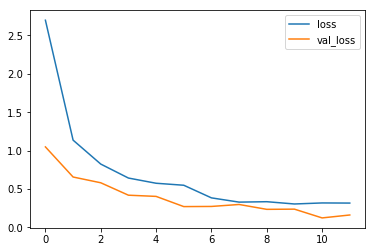


!!! Done at 2019-02-22 09:59:33.541918!!!


In [4]:

from keras.callbacks import EarlyStopping

early = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')

history = model.fit_generator(train_data_generator,
          epochs=12,
          steps_per_epoch=32, 
          verbose=1,
          callbacks=[plot_losses, early],
          validation_data=valid_data_generator,
          validation_steps=8)

print()
print("!!! Done at {}!!!".format(datetime.datetime.now()))

8/8 [==============================] - 2s 210ms/step
Correct: 0  Total:  6379
Loss:  0.13933928776532412 Accuracy:  0.94921875
dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


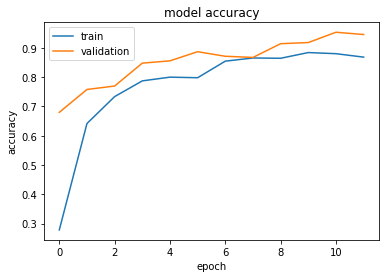

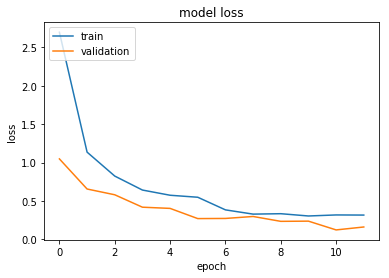


!!! Done at 2019-02-22 09:59:42.696496!!!


In [5]:
score = model.evaluate_generator(valid_data_generator, verbose=1, steps=8)
scores = model.predict_generator(valid_data_generator, verbose=1, steps=8)

correct = 0
for i, n in enumerate(valid_data_generator.filenames):
    if n.startswith("cats") and scores[i][0] <= 0.5:
        correct += 1
    if n.startswith("dogs") and scores[i][0] > 0.5:
        correct += 1

print("Correct:", correct, " Total: ", len(valid_data_generator.filenames))
print("Loss: ", score[0], "Accuracy: ", score[1])

#plot(history)

print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


print()
print("!!! Done at {}!!!".format(datetime.datetime.now()))

In [6]:
# serialize model to JSON
model_json = model.to_json()
with open("lego.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("lego.h5")
print("Saved model to disk")

print()
print("!!! Done at {}!!!".format(datetime.datetime.now()))

Saved model to disk

!!! Done at 2019-02-22 09:59:43.918669!!!
